In [1]:
import pandas as pd
import numpy as np
import os
import umap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import sys
from PIL import Image
from umap.umap_ import UMAP

In [2]:
quantified_directory = '/home/mass_spec_img/mass_spec_img/data/quantified_3snr'
df = pd.DataFrame()
y_max = 0
slide_names = ['SQ1632', 'SQ1633', 'SQ1634', 'SQ1635', 'SQ1636']
tissue_names = ['S1', 'S2', 'S3', 'S4']
for s in slide_names:
    slide_df = pd.DataFrame()
    for t in tissue_names:
        st = s+t+"_quantified_3snr.tsv"
        sub_df = pd.read_csv(os.path.join(quantified_directory, st), sep="\t")
        scaler = MinMaxScaler()
        for column in sub_df.columns[2:]:
            sub_df[column] = scaler.fit_transform(sub_df[[column]])
        slide_df = pd.concat([slide_df, sub_df], axis=0)
    slide_df['Y'] += y_max
    y_max = slide_df['Y'].max()
    df = pd.concat([df, slide_df], axis=0)
#df.to_csv("/home/mass_spec_img/mass_spec_img/data/quantified/SQ1632_1636_3snr.tsv", sep="\t", index=False)




In [3]:
df.head()

X    Y  mz798.543_mob1.46  mz772.526_mob1.43  mz826.575_mob1.48  \
0  1220  457           0.477718           0.075100           0.266608   
1  1221  457           0.469519           0.071673           0.271036   
2  1222  457           0.461676           0.074529           0.256864   
3  1223  457           0.491266           0.073101           0.265722   
4  1224  457           0.425312           0.061108           0.240035   

   mz713.451_mob1.36  mz534.292_mob1.15  mz820.519_mob1.45  mz734.57_mob1.41  \
0           0.028465           0.210300           0.236806          0.063260   
1           0.026609           0.253219           0.213802          0.054745   
2           0.029084           0.287554           0.230041          0.048662   
3           0.021040           0.257511           0.250338          0.052311   
4           0.018564           0.167382           0.270636          0.043796   

   mz770.505_mob1.42  ...  mz720.936_mob1.12  mz976.549_mob1.54  \
0           0.344147  ...           0.382979           0.230769   
1           0.331453  ...           0.829787           0.230769   
2           0.299013  ...           0.531915           0.211538   
3           0.328632  ...           0.425532           0.115385   
4           0.299013  ...           0.489362           0.115385   

   mz927.897_mob1.29  mz555.926_mob1.04  mz399.922_mob1.0  mz998.541_mob1.56  \
0           0.159091           0.800000          0.322581           0.000000   
1           0.250000           0.833333          0.258065           0.136364   
2           0.340909           0.533333          0.161290           0.250000   
3           0.409091           0.233333          0.419355           0.090909   
4           0.363636           0.733333          0.225806           0.159091   

   mz773.935_mob1.18  mz694.877_mob1.05  mz1124.883_mob1.4  mz407.959_mob1.06  
0           0.000000           0.000000           0.230769           0.166667  
1           0.225806           0.409091           0.000000           0.166667  
2           0.096774           0.136364           0.346154           0.166667  
3           0.193548           0.590909           0.000000           0.000000  
4           0.000000           0.272727           0.000000           0.000000  

[5 rows x 246 columns]

In [4]:
def colnorm(X):
    return X / np.sum(X, axis=0, keepdims=True)


def plsa(X, num_components, relative_change=1e-4, maxIter=1000):
    pca_scaler = None
    Xt = np.transpose(X)
    (num_channels, num_spectra) = Xt.shape

    eps =  np.finfo(float).eps
    ct = colnorm(np.random.rand(num_channels, num_components));
    ts = colnorm(np.ones((num_components, num_spectra)))

    last_change = 1.0 / eps
    err = 1e10
    iteration = 0

    while (last_change > relative_change) and (iteration < maxIter):
        ts = colnorm(np.multiply(ts, np.matmul(np.transpose(ct), np.divide(Xt, (np.matmul(ct, ts) + eps)))))
        ct = colnorm(np.multiply(ct, np.matmul(np.divide(Xt, (np.matmul(ct,ts) + eps)), np.transpose(ts))))

        model = np.multiply(np.matmul(np.ones((num_channels, 1)), np.sum(Xt, axis=0, keepdims=True)), np.matmul(ct, ts))
        errold = err
        err = np.sum(np.square(np.subtract(Xt, model)))
        
        last_change = abs((err - errold) / err)
        iteration = iteration + 1

        if not (iteration % 25 ):
            print(f"Iteration {iteration}: relative change is {last_change}")

    loglik = np.sum(np.multiply(Xt, np.log(np.matmul(ct, ts) + eps)))

    return((ct, ts, loglik))

def spartial_visualize(df, n_components=3, method="PCA"):
    data = df.iloc[:, 2:].to_numpy()

    if method == "UMAP":
        fit = UMAP(n_components=n_components)
        data = fit.fit_transform(data)

    if method == "PLSA":
        (ct, wt, loglik) = plsa(data, num_components=3)
        data = np.transpose(wt)

    if method == "PCA":
        pca_data = StandardScaler().fit_transform(data)
        pca_scaler = PCA(n_components=n_components)
        data = pca_scaler.fit_transform(pca_data) 

    

    # get the coordinates of the pixels for the output image
    xmin, xmax = df['X'].min(), df['X'].max()
    ymin, ymax = df['Y'].min(), df['Y'].max()
    df['X'] -= xmin
    df['Y'] -= ymin

    width = xmax - xmin + 1
    height = ymax - ymin + 1

    pca_mode = False
    if (np.max(data) > 1) or (np.min(data) < 0):
        pca_mode = True
        for i in range(data.shape[1]):
            v = data[:, i]
            data[:, i] = (v - v.min()) / (v.max() - v.min())

    img = Image.new('RGB', (width, height), color='black')

    red_color = np.array((255, 0, 0))
    cred_color = np.array((0, 255, 255))
    green_color = np.array((0, 255, 0))
    cgreen_color = np.array((255, 0, 255))
    blue_color = np.array((0, 0, 255))
    cblue_color = np.array((255, 255, 0))

    xp = 1
    
    for r in range(data.shape[0]):
        the_color = np.zeros(3)
        i = 0
        rval = (data[r,i] - 0.5) / 0.5
        if rval > 0:
            the_color += rval * red_color
        else:
            the_color += (-1 * rval) * cred_color
        i = 1
        gval = (data[r,i] - 0.5) / 0.5
        if gval > 0:
            the_color += gval * green_color
        else:
            the_color += (-1 * gval) * cgreen_color
        i = 2
        bval = (data[r,i] - 0.5) / 0.5
        if bval > 0:
            the_color += bval * blue_color
        else:
            the_color += (-1 * bval) * cblue_color

        the_color /= (255 * 3)

        the_color *= 255

        for i in range(xp):
            for j in range(xp):
                img.putpixel((df.iloc[r,0] + i,df.iloc[r,1] + j), tuple(np.int32(the_color)))

    return img, pca_scaler


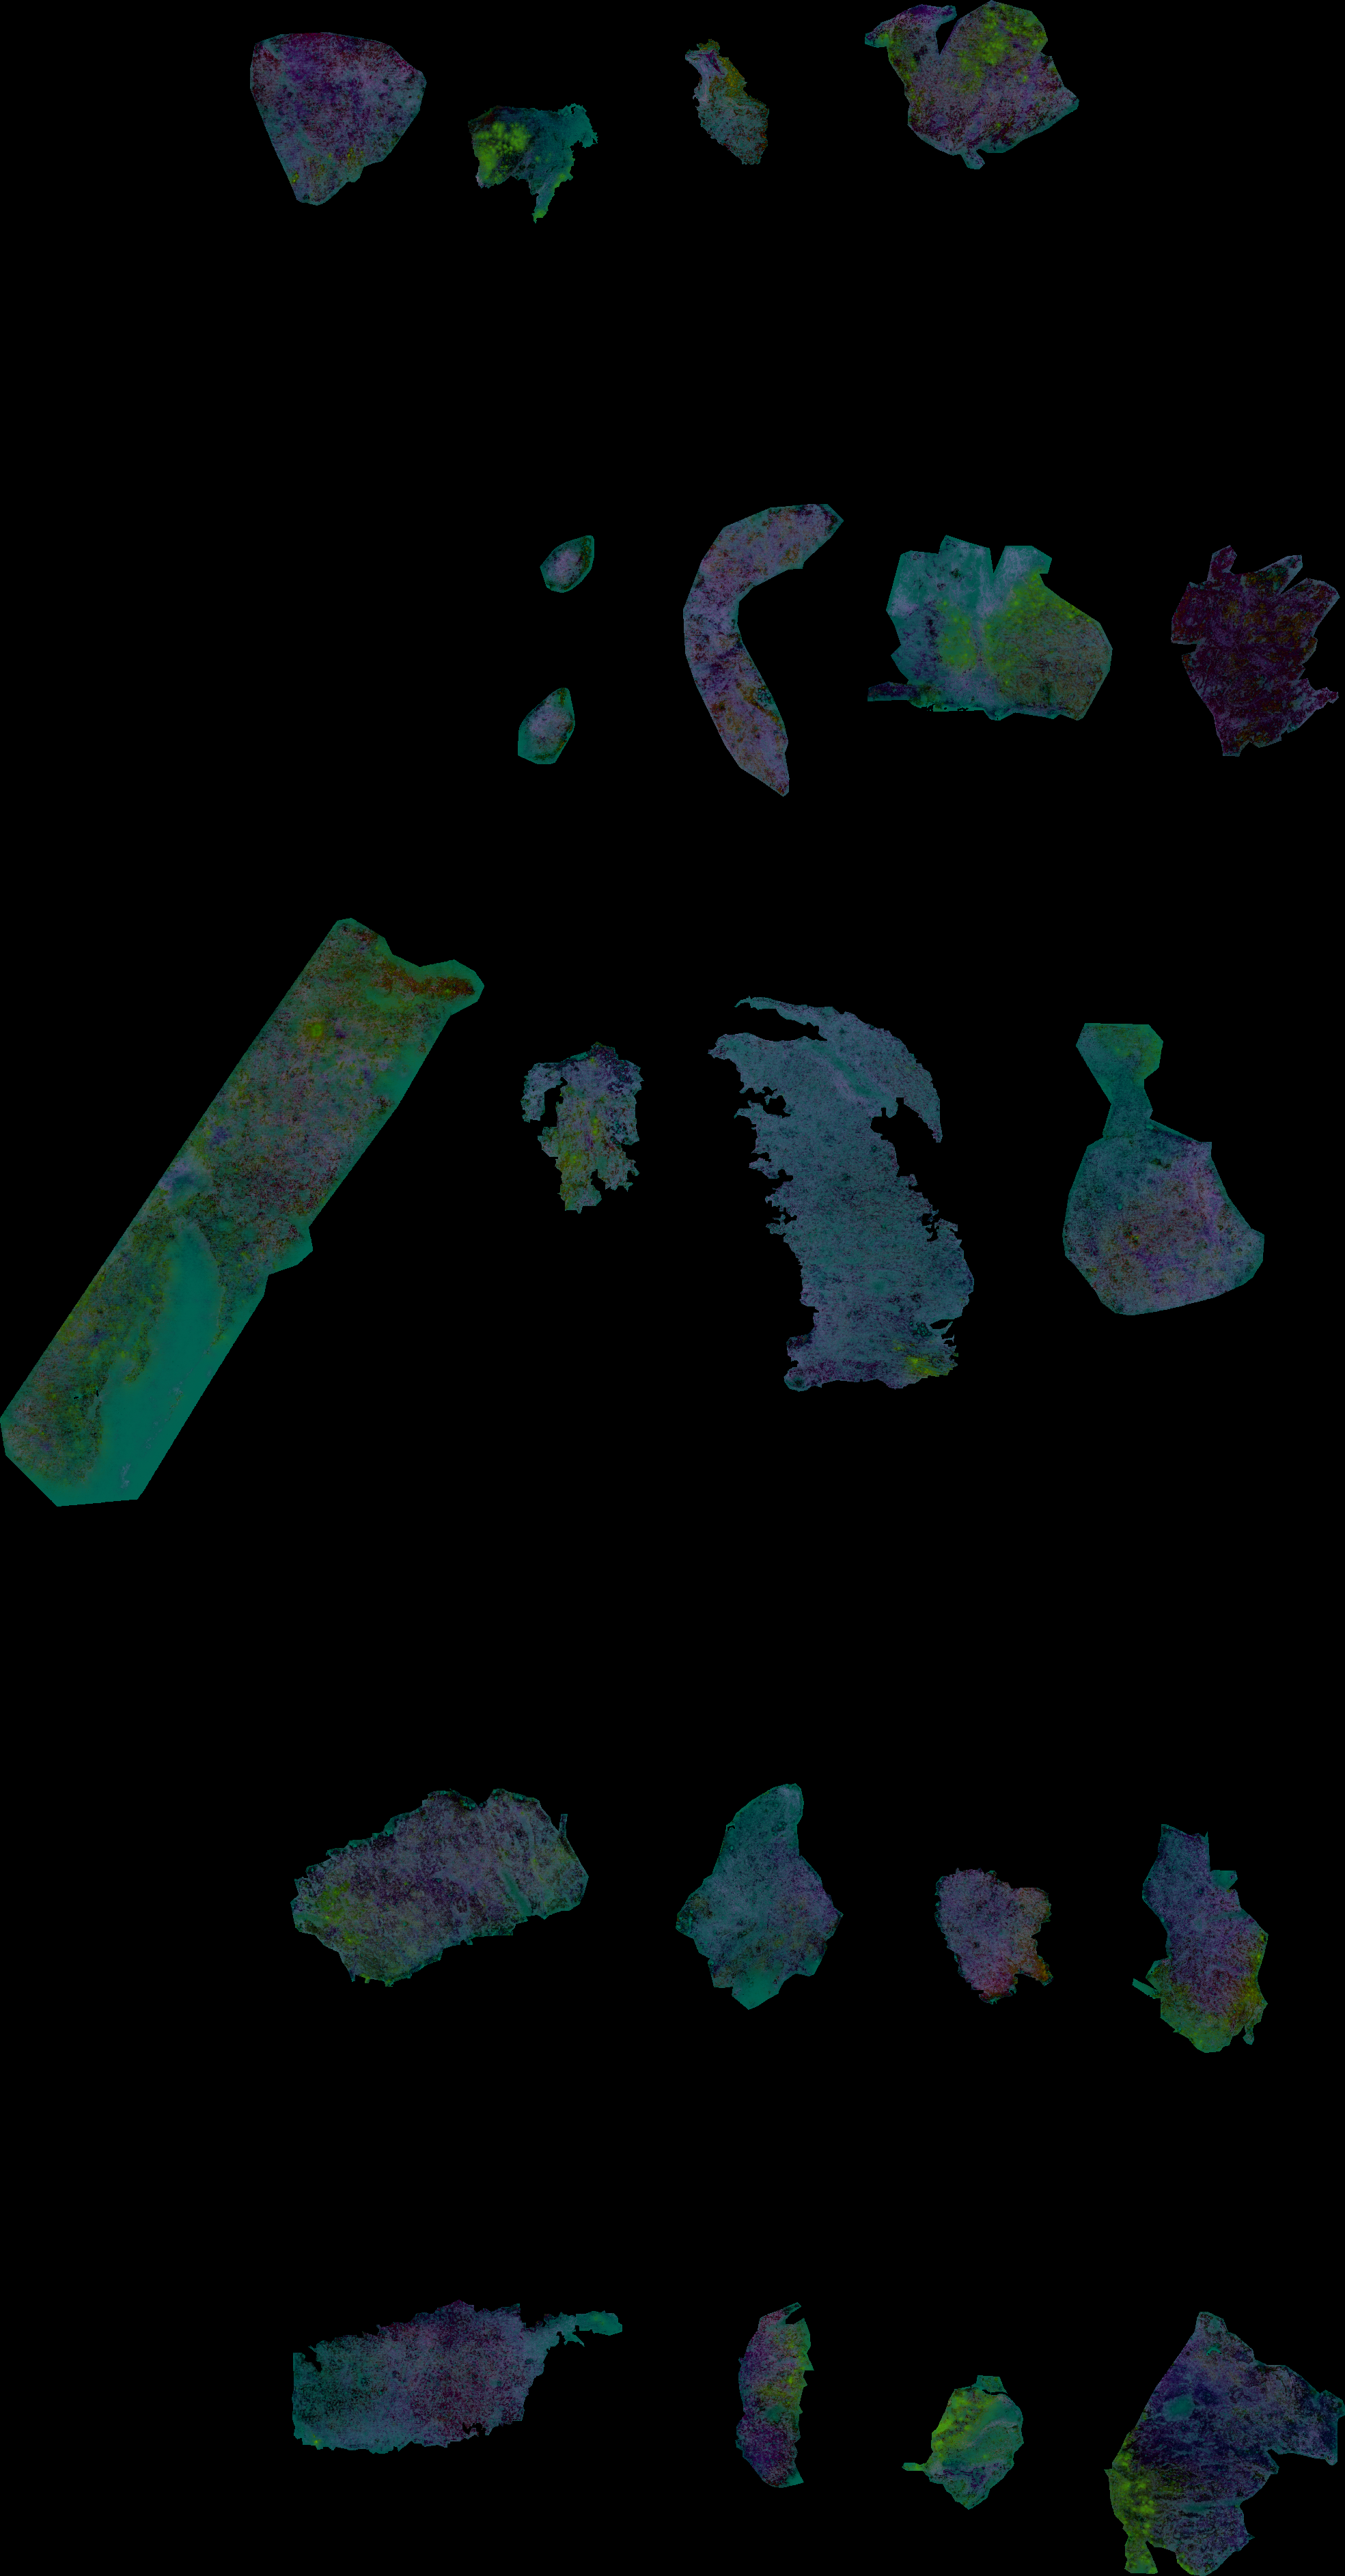

In [5]:
img, pca_scaler = spartial_visualize(df, 3, "PCA")
display(img)

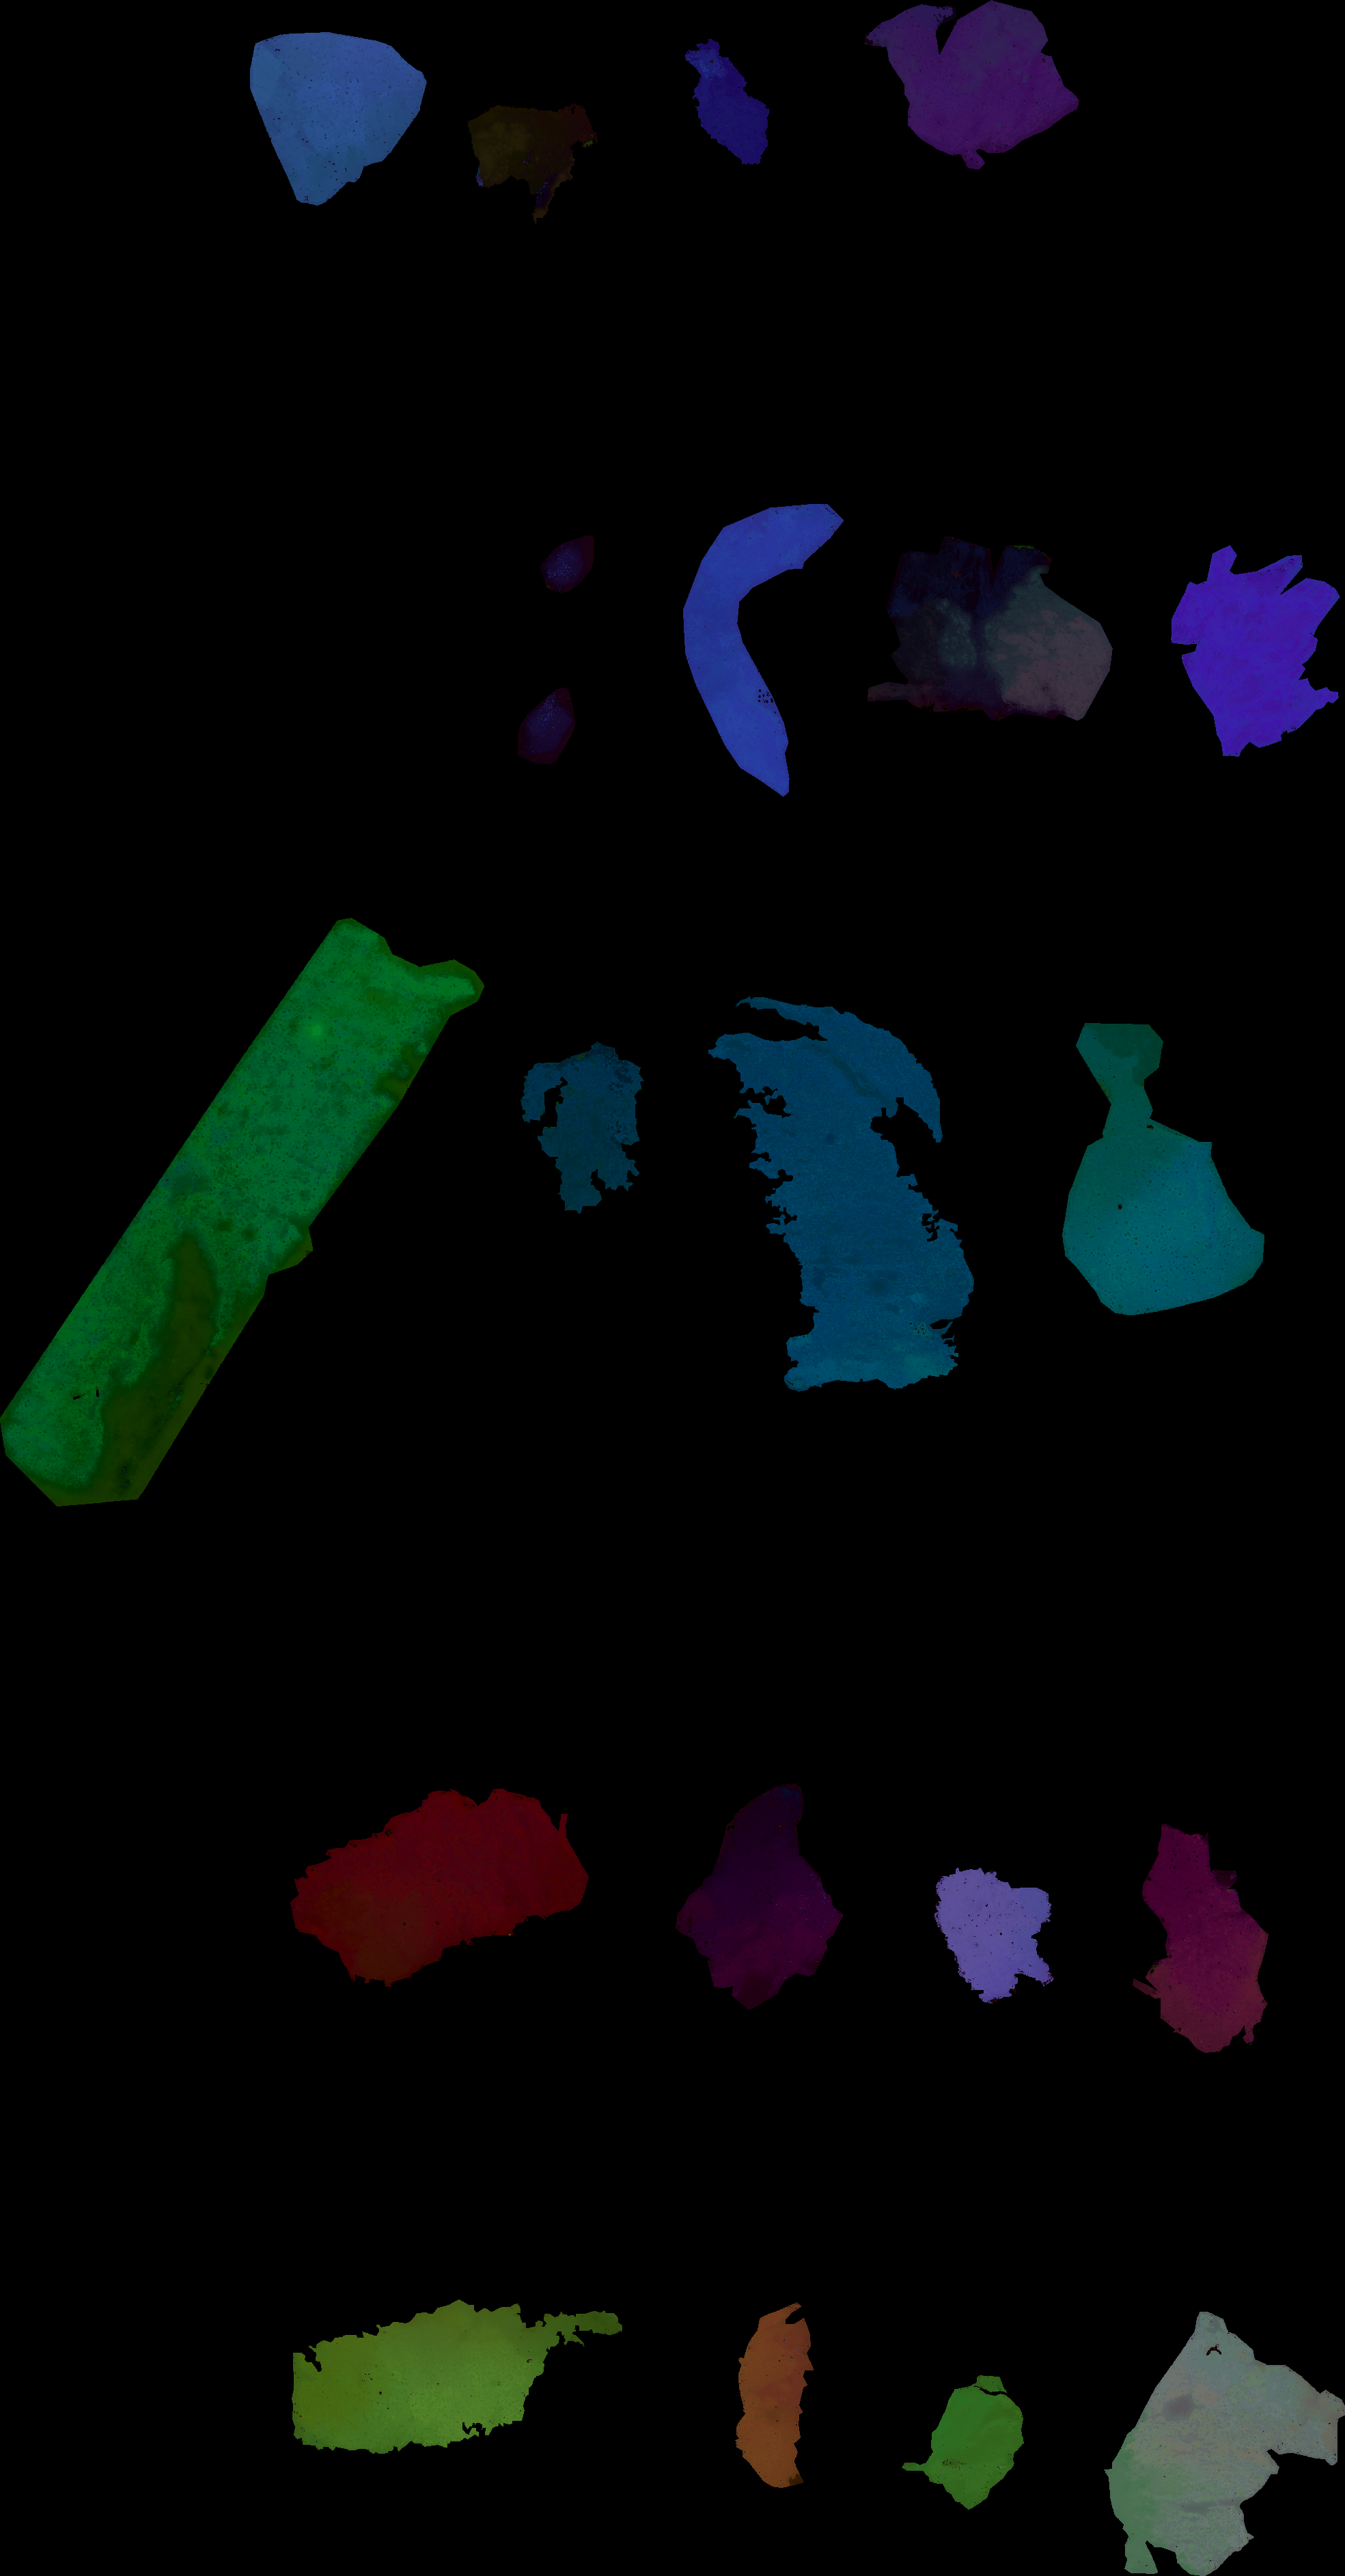

In [6]:
img = spartial_visualize(df, 3, "UMAP")
display(img)

In [7]:
feature_weights = pd.DataFrame(
    pca_scaler.components_.T,  # Transpose to get features as rows, PCs as columns
    columns=[f'PC{i+1}' for i in range(pca_scaler.n_components_)],
    index=df.columns[2:]
)

# Get the transformed data points
# This shows each original data point in the new PC space
transformed_df = pd.DataFrame(
    df.iloc[:, 2:],
    columns=[f'PC{i+1}' for i in range(pca_scaler.n_components_)]
)

# If you want to see how much each PC explains the variance
explained_variance = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(pca_scaler.n_components_)],
    'Explained Variance Ratio': pca_scaler.explained_variance_ratio_,
    'Cumulative Variance Ratio': np.cumsum(pca_scaler.explained_variance_ratio_)
})


In [8]:
# Display the results
print("Feature loadings for each principal component:")
print(feature_weights)
print("\nTransformed data points:")
print(transformed_df.head())
print("\nExplained variance:")
print(explained_variance)

Feature loadings for each principal component:
                        PC1       PC2       PC3
mz798.543_mob1.46  0.078041 -0.026338 -0.013382
mz772.526_mob1.43  0.067569  0.065847 -0.137389
mz826.575_mob1.48  0.099062 -0.040054  0.029657
mz713.451_mob1.36  0.080495  0.066089 -0.105496
mz534.292_mob1.15  0.047263  0.003619 -0.062255
...                     ...       ...       ...
mz998.541_mob1.56  0.065463 -0.004178  0.007540
mz773.935_mob1.18 -0.020917 -0.064555 -0.045620
mz694.877_mob1.05 -0.020105 -0.020788 -0.019391
mz1124.883_mob1.4 -0.008699 -0.066783 -0.036180
mz407.959_mob1.06 -0.012011 -0.036416 -0.021205

[244 rows x 3 columns]

Transformed data points:
   PC1  PC2  PC3
0  NaN  NaN  NaN
1  NaN  NaN  NaN
2  NaN  NaN  NaN
3  NaN  NaN  NaN
4  NaN  NaN  NaN

Explained variance:
    PC  Explained Variance Ratio  Cumulative Variance Ratio
0  PC1                  0.255463                   0.255463
1  PC2                  0.153870                   0.409333
2  PC3                  

  Top features for PC1 Top features for PC2 Top features for PC3
0    mz800.545_mob1.46   mz1158.909_mob1.44    mz770.505_mob1.42
1    mz741.471_mob1.37    mz982.901_mob1.32     mz744.495_mob1.4
2    mz739.466_mob1.37    mz750.879_mob1.14    mz771.506_mob1.42
3    mz740.464_mob1.38    mz983.902_mob1.32    mz946.514_mob1.52
4    mz801.559_mob1.46    mz791.921_mob1.18    mz742.471_mob1.39
5    mz763.466_mob1.37    mz811.892_mob1.17    mz711.435_mob1.34
6    mz766.487_mob1.39    mz636.888_mob1.08    mz712.438_mob1.34
7    mz738.449_mob1.36   mz1180.888_mob1.42    mz772.526_mob1.43
8    mz764.471_mob1.37    mz614.912_mob1.07    mz758.506_mob1.42
9    mz826.575_mob1.48     mz422.93_mob1.06     mz732.551_mob1.4


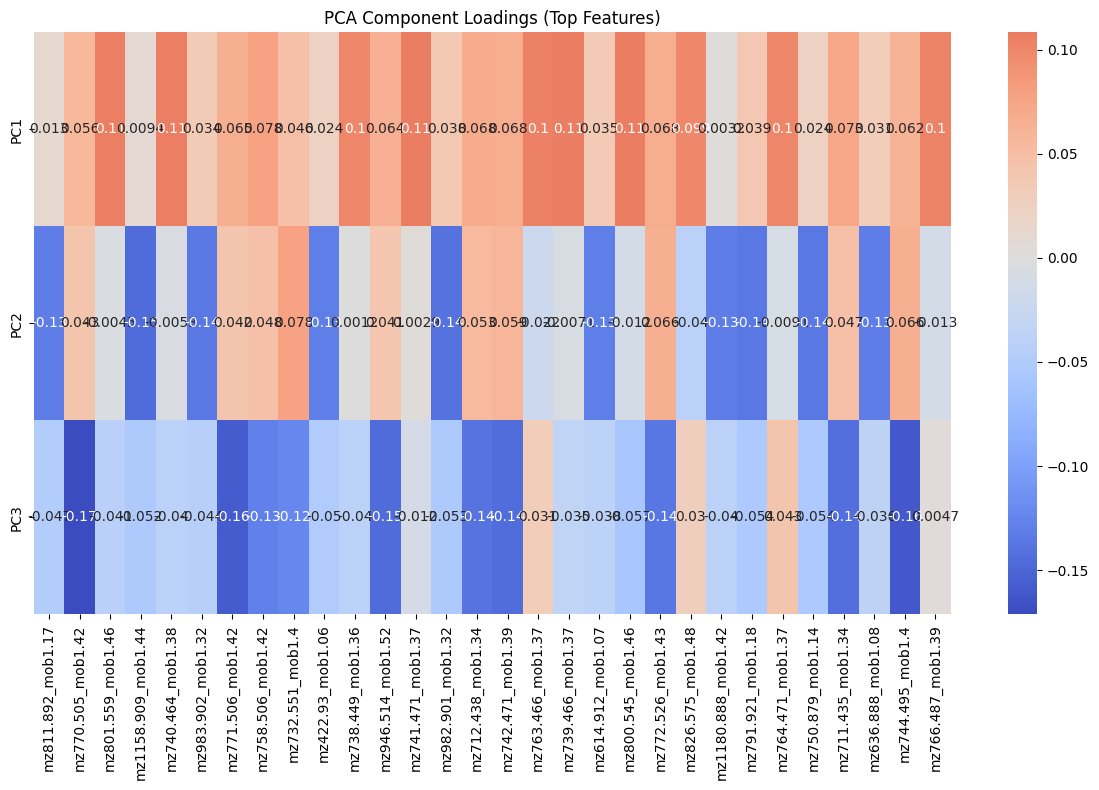

In [14]:
import seaborn as sns
loadings = pca_scaler.components_

loadings_df = pd.DataFrame(
    loadings,
    columns=df.columns[2:],  # Replace with your actual column names if different
    index=['PC1', 'PC2', 'PC3']
)
def get_top_features(loadings_df, n=10):
    top_features = pd.DataFrame()
    
    for i, component in enumerate(loadings_df.index):
        # Get absolute loadings and sort
        sorted_loadings = loadings_df.loc[component].abs().sort_values(ascending=False)
        # Keep top n features
        top_n = sorted_loadings.iloc[:n].index.tolist()
        top_features[f'Top features for {component}'] = pd.Series(top_n)
    
    return top_features

# Get top 10 features for each component
top_features = get_top_features(loadings_df, n=10)
print(top_features)

# Create filtered loadings DataFrame with only top features from all components
all_top_features = set()
for col in top_features.columns:
    all_top_features.update(top_features[col].dropna().tolist())

# Filter the loadings to only include these top features
filtered_loadings = loadings_df[list(all_top_features)]

# Create a more readable heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_loadings, cmap='coolwarm', center=0, annot=True)
plt.title('PCA Component Loadings (Top Features)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()